In [1]:
import pickle
import yaml
import torch

import numpy as np
import matplotlib.pyplot as plt
import arviz as az

plt.rcParams.update({
    "text.usetex": True,
    "font.family": "mathptmx",
    'font.size': 20
})

In [2]:

domain = [-1, 1]


In [3]:
def calculate_mean_and_quantile(x_preds):
    x_mean = torch.mean(x_preds, axis=0)
    #lower_quantile = torch.quantile(x_preds, 0.05, axis=0)
    #upper_quantile = torch.quantile(x_preds, 0.95, axis=0)

    lower_quantile = az.hdi(x_preds.detach().numpy(), hdi_prob=0.95)
    
    upper_quantile = lower_quantile[:,1]
    lower_quantile = lower_quantile[:,0]

    return x_mean, lower_quantile, upper_quantile

def plot_results(config, t, x, true, y_data, x_preds):
    x_mean, lower_quantile, upper_quantile = calculate_mean_and_quantile(x_preds)

    plt.figure()
    plt.plot(x, true, label='true')
    plt.plot(t, y_data, label='data')

    line, = plt.plot(t, x_mean, label='inverse solution')
    # Plot the quantile range as a shaded area
    plt.fill_between(x, lower_quantile, upper_quantile, color=line.get_color(), alpha=0.5, label='90% quantile range')
    #plt.plot(t, A@x_solution.numpy(), label='A @ solution')
    plt.axis([domain[0], domain[1], -0.1, 1.5])
    plt.xlabel('t')
    plt.ylabel('x')

    plt.savefig(f"plots/{config['plot_parameters']['solution_plot']}")


def plot_problem(problem_type: str,
                 config_name: str):

    with open(f'../results/{problem_type}_{config_name}.pickle', 'rb') as handle:
        data = pickle.load(handle)

    plt.figure()
    plt.plot(data['t'], data['true'],linewidth=0.7)
    plt.plot(data['x'], data['y_data'],linewidth=0.7)

    plt.axis([domain[0], domain[1], -0.5, 1.5])
    plt.savefig(f"../plots/{config_name}_problem.png")


def plot_initials():

    with open(f'../results/continuous_initial.pickle', 'rb') as handle:
        data_continuous = pickle.load(handle)
    with open(f'../results/discrete_initial.pickle', 'rb') as handle:
        data_discrete = pickle.load(handle)
    with open(f'../results/combined_initial.pickle', 'rb') as handle:
        data_combined = pickle.load(handle)

    fig, axs = plt.subplots(1, 3, figsize=(16, 5))
    axs[0].plot(data_continuous['t'], data_continuous['true'])
    axs[0].plot(data_continuous['x'], data_continuous['y_data'])
    axs[0].axis([domain[0], domain[1], -1.0, 1.0])

    axs[1].plot(data_discrete['t'], data_discrete['true'])
    axs[1].plot(data_discrete['x'], data_discrete['y_data'])
    axs[1].axis([domain[0], domain[1], -1.0, 1.0])

    axs[2].plot(data_combined['t'], data_combined['true'])
    axs[2].plot(data_combined['x'], data_combined['y_data'])
    axs[2].axis([domain[0], domain[1], -0.5, 1.5])



    plt.savefig(f"../plots/thesis_images/initial_problems.pdf", format='pdf')

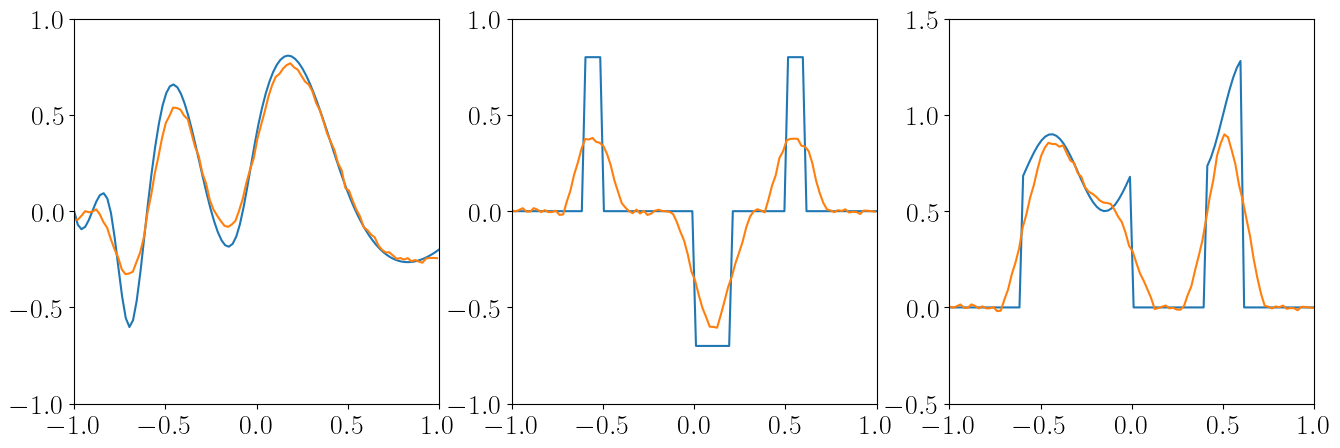

In [4]:
plot_initials()

## $\sigma$

In [5]:
def plot_sigma_subplots(config, problem_type, experiment_type):

    initial = yaml.safe_load(open(f"config/initial.yml"))
    config = yaml.safe_load(open(f"config/{config}"))

    fig, axs = plt.subplots(2, 2, figsize=(16, 10))
    ii, jj = 0, 0
    with open(f'../results/{problem_type}_initial.pickle', 'rb') as handle:
        data = pickle.load(handle)

    x_mean, lower_quantile, upper_quantile = calculate_mean_and_quantile(data['x_preds'])

    axs[ii, jj].plot(data['t'], data['true'])
    axs[ii, jj].plot(data['x'], data['y_data'])

    line, = axs[ii, jj].plot(data['t'], x_mean, label='inverse solution')
    axs[ii, jj].fill_between(data['t'], lower_quantile, upper_quantile, color=line.get_color(), alpha=0.2, label='90% quantile range')
    
    axs[ii, jj].set_title(f'$\sigma^2= {initial[problem_type]["sigma_noise"]}^2$')

    if problem_type == 'combined':
        axs[ii, jj].axis([domain[0], domain[1], -0.5, 1.5])
    else:
        axs[ii, jj].axis([domain[0], domain[1], -1.0, 1.0])

    jj = jj +1

    for idx, conf in enumerate(config):
        with open(f'../results/{problem_type}_{conf}.pickle', 'rb') as handle:
            data = pickle.load(handle)
        
        x_mean, lower_quantile, upper_quantile = calculate_mean_and_quantile(data['x_preds'])

        axs[ii, jj].plot(data['t'], data['true'])
        axs[ii, jj].plot(data['x'], data['y_data'])

        line, = axs[ii, jj].plot(data['t'], x_mean, label='inverse solution')
        axs[ii, jj].fill_between(data['t'], lower_quantile, upper_quantile, color=line.get_color(), alpha=0.2, label='90% quantile range')
        
        axs[ii, jj].set_title(f'$\sigma^2= {config[conf]["sigma_noise"]}^2$')

        if problem_type == 'combined':
            axs[ii, jj].axis([domain[0], domain[1], -0.5, 1.5])
        else:
            axs[ii, jj].axis([domain[0], domain[1], -1.0, 1.0])

        jj = jj +1
        if jj >1:
            ii = ii +1
            jj = 0
    #plt.tight_layout()
    plt.savefig(f"../plots/thesis_images/sigma_{problem_type}.pdf", format='pdf')



/home/akseli/anaconda3/lib/python3.9/site-packages/arviz/stats/stats.py:456: FutureWarning: hdi currently interprets 2d data as (draw, shape) but this will change in a future release to (chain, draw) for coherence with other functions
  warnings.warn(


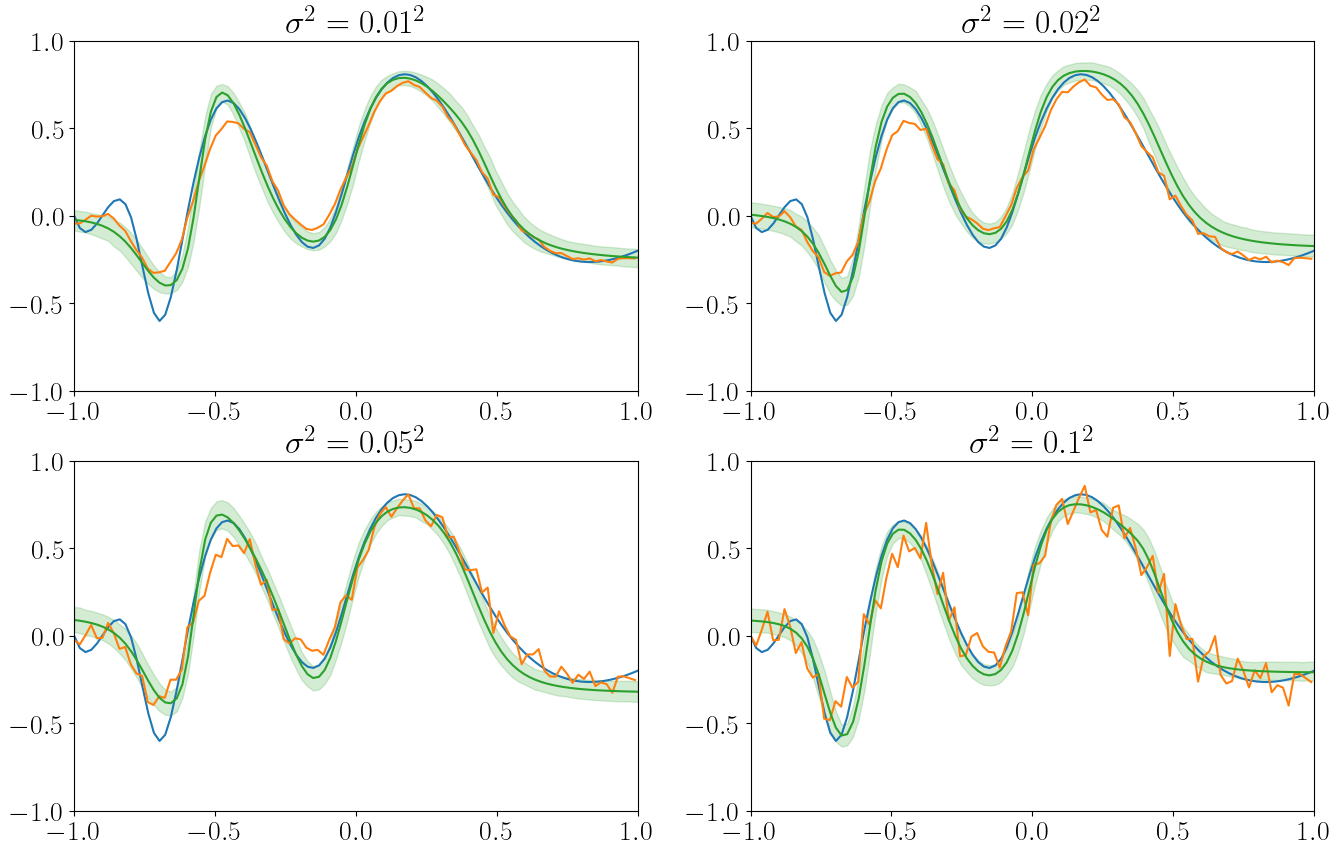

In [6]:
plot_sigma_subplots('continuous_sigma.yml', 'continuous','sigma')

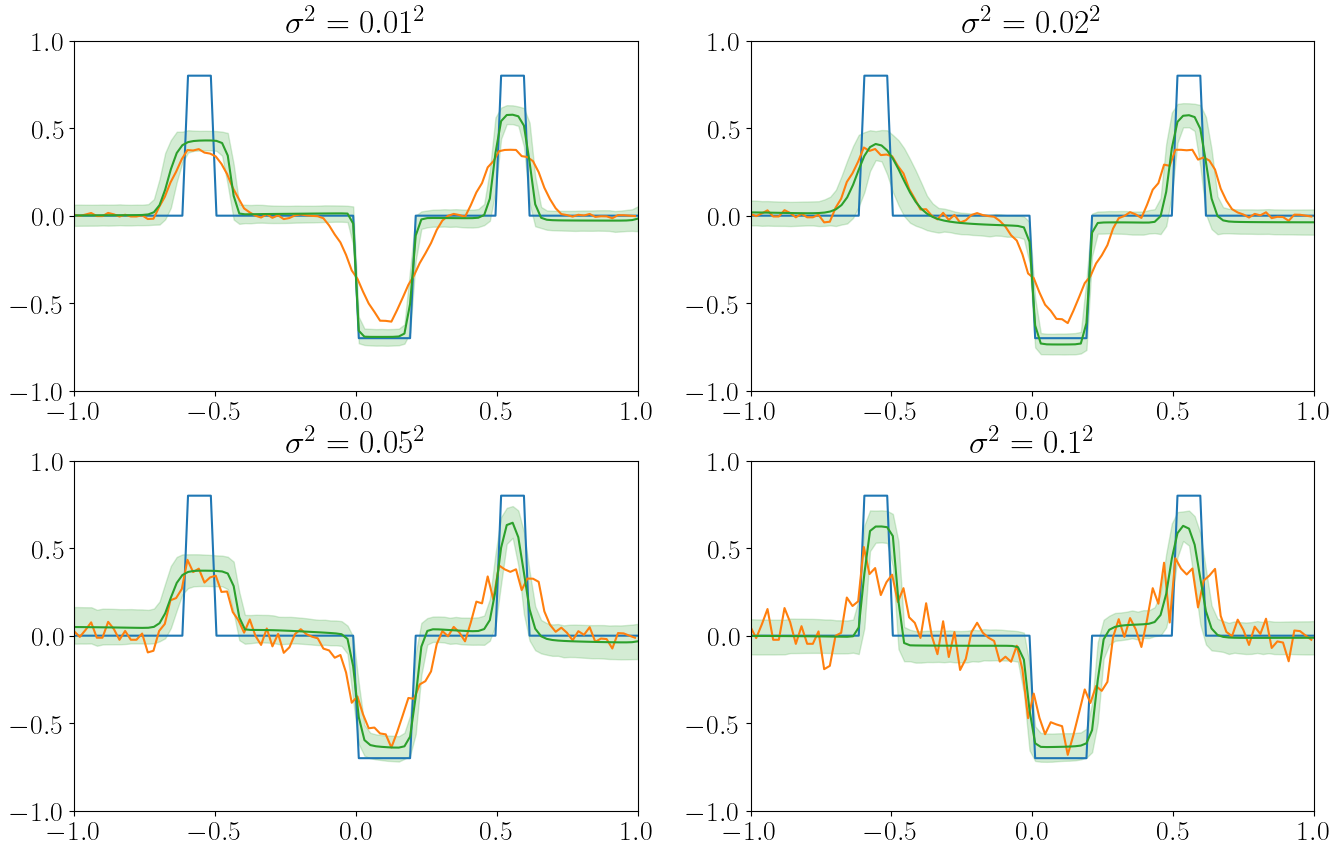

In [7]:
plot_sigma_subplots('discrete_sigma.yml', 'discrete','sigma')

FileNotFoundError: [Errno 2] No such file or directory: '../results/combined_ssigma_002.pickle'

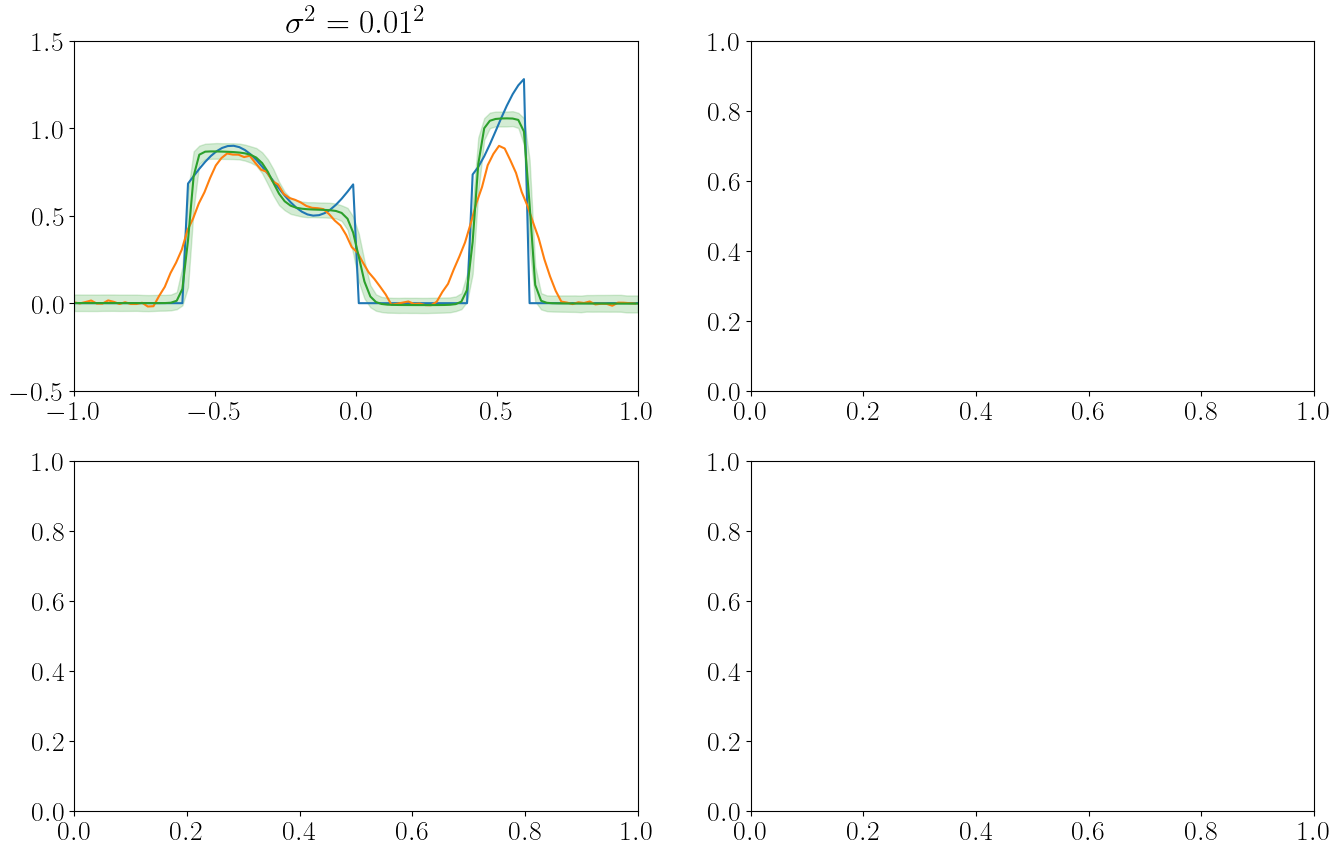

In [8]:
plot_sigma_subplots('combined_sigma.yml', 'combined','sigma')

## Iterations

In [9]:
def plot_iterations_subplots(configs, problem_type, experiment_type):

    initial = yaml.safe_load(open(f"config/initial.yml"))
    config = yaml.safe_load(open(f"config/{configs}"))

    fig, axs = plt.subplots(2, 2, figsize=(16, 10))
    ii, jj = 0, 0
   
    for idx, conf in enumerate(config):
        with open(f'../results/{problem_type}_{conf}.pickle', 'rb') as handle:
            data = pickle.load(handle)
        
        x_mean, lower_quantile, upper_quantile = calculate_mean_and_quantile(data['x_preds'])

        axs[ii, jj].plot(data['t'], data['true'])
        axs[ii, jj].plot(data['x'], data['y_data'])

        line, = axs[ii, jj].plot(data['t'], x_mean, label='inverse solution')
        axs[ii, jj].fill_between(data['t'], lower_quantile, upper_quantile, color=line.get_color(), alpha=0.2, label='90% quantile range')
        
        axs[ii, jj].set_title(f'$n= {config[conf]["training_parameters"]["svi_num_iterations"]}$')

        if problem_type == 'combined':
            axs[ii, jj].axis([domain[0], domain[1], -0.5, 1.5])
        else:
            axs[ii, jj].axis([domain[0], domain[1], -1.0, 1.0])

        jj = jj +1
        if jj >1:
            ii = ii +1
            jj = 0
    #plt.tight_layout()
    plt.savefig(f"../plots/thesis_images/iterations_{problem_type}.pdf", format='pdf')

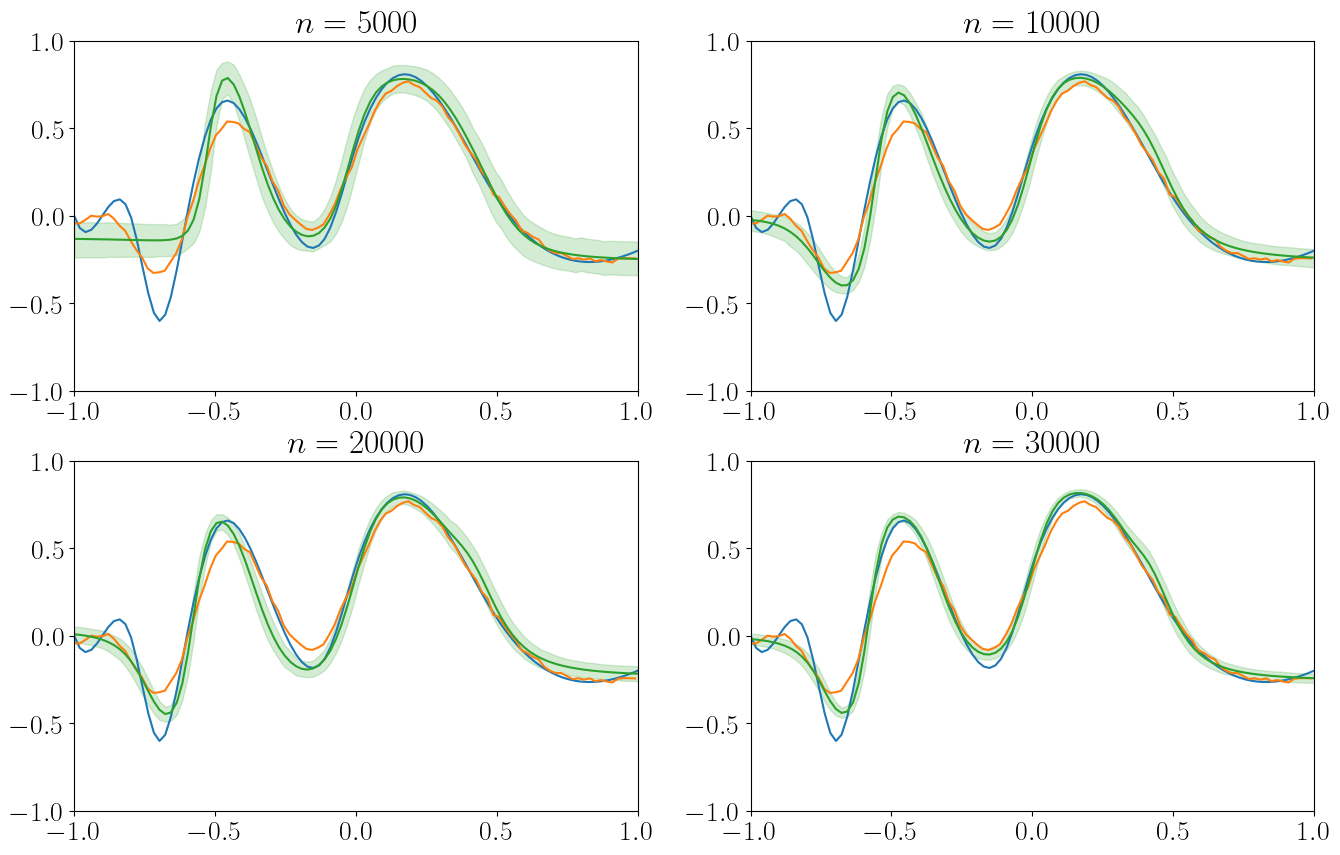

In [10]:
plot_iterations_subplots('continuous_iterations.yml', 'continuous', 'iterations')

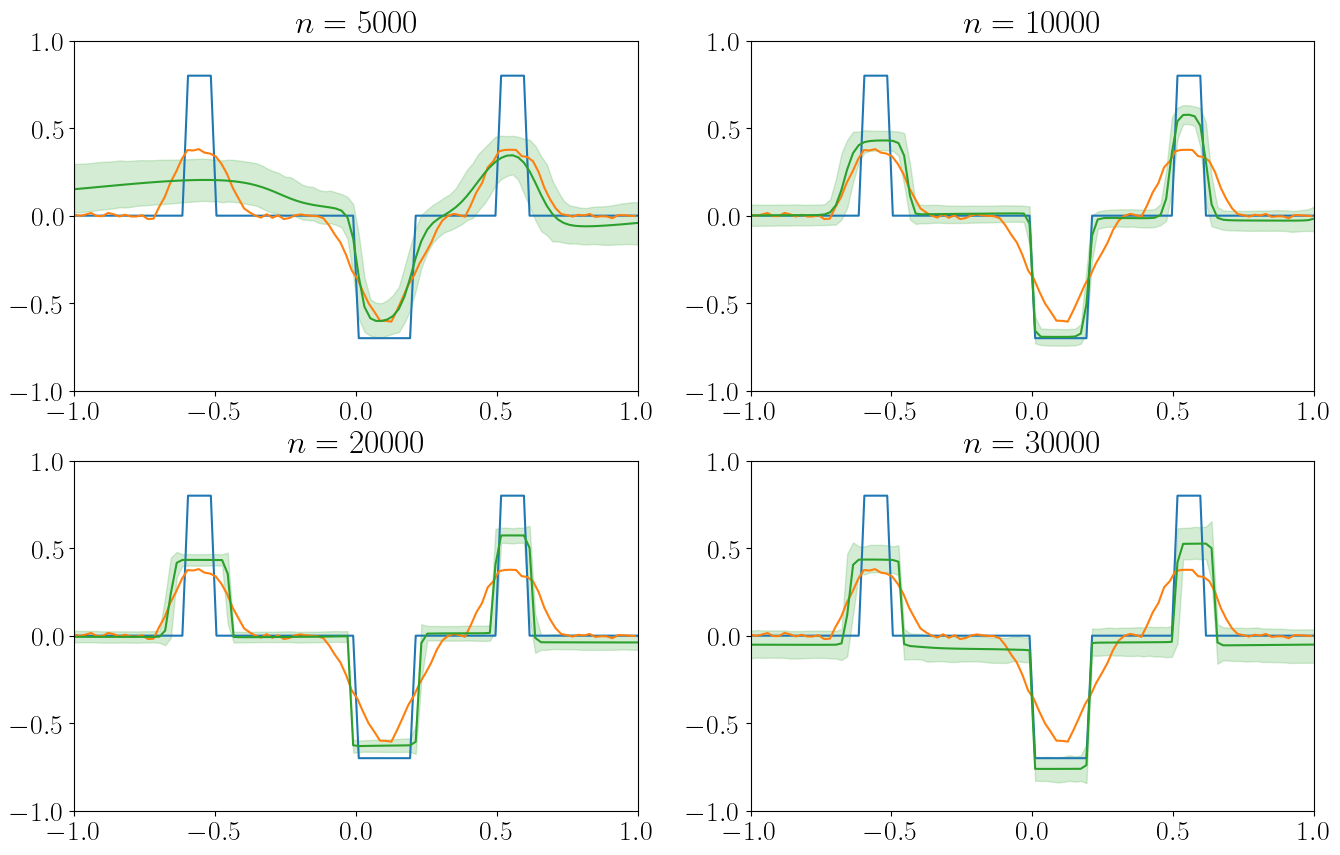

In [11]:
plot_iterations_subplots('discrete_iterations.yml', 'discrete', 'iterations')

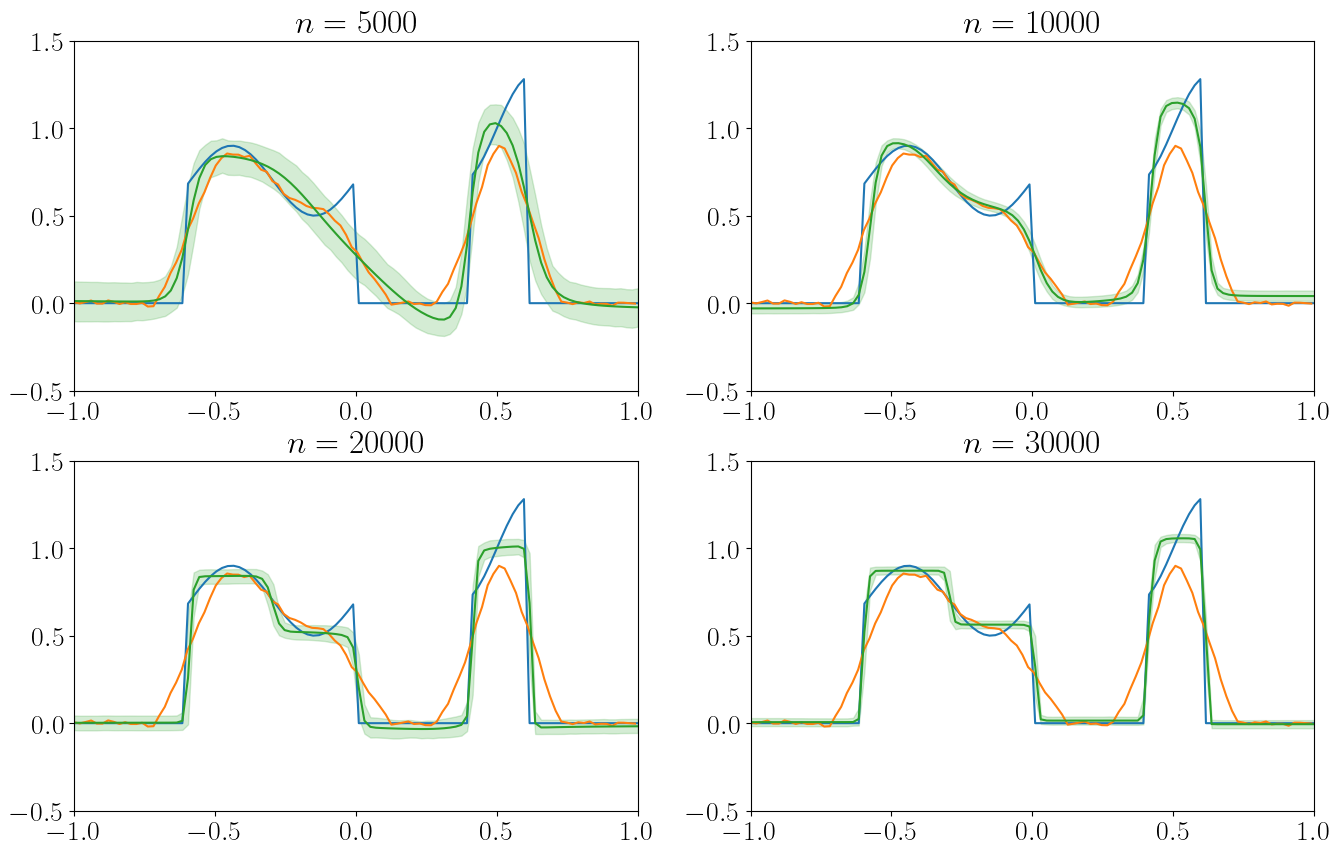

In [12]:
plot_iterations_subplots('discrete_iterations.yml', 'combined', 'iterations')

## T

In [13]:
def plot_t_subplots(config, problem_type, experiment_type):

    initial = yaml.safe_load(open(f"config/initial.yml"))
    config = yaml.safe_load(open(f"config/{config}"))

    fig, axs = plt.subplots(2, 2, figsize=(16, 10))
    ii, jj = 0, 0
    with open(f'../results/{problem_type}_initial.pickle', 'rb') as handle:
        data = pickle.load(handle)

    x_mean, lower_quantile, upper_quantile = calculate_mean_and_quantile(data['x_preds'])

    axs[ii, jj].plot(data['t'], data['true'])
    axs[ii, jj].plot(data['x'], data['y_data'])

    line, = axs[ii, jj].plot(data['t'], x_mean, label='inverse solution')
    axs[ii, jj].fill_between(data['t'], lower_quantile, upper_quantile, color=line.get_color(), alpha=0.2, label='90% quantile range')
    
    axs[ii, jj].set_title(f'$t= {initial[problem_type]["n_t"]}$')

    if problem_type == 'combined':
        axs[ii, jj].axis([domain[0], domain[1], -0.5, 1.5])
    else:
        axs[ii, jj].axis([domain[0], domain[1], -1.0, 1.0])

    jj = jj +1

    for idx, conf in enumerate(config):
        with open(f'../results/{conf}.pickle', 'rb') as handle:
            data = pickle.load(handle)
        
        x_mean, lower_quantile, upper_quantile = calculate_mean_and_quantile(data['x_preds'])

        axs[ii, jj].plot(data['t'], data['true'])
        axs[ii, jj].plot(data['x'], data['y_data'])

        line, = axs[ii, jj].plot(data['t'], x_mean, label='inverse solution')
        axs[ii, jj].fill_between(data['t'], lower_quantile, upper_quantile, color=line.get_color(), alpha=0.2, label='90% quantile range')
        
        axs[ii, jj].set_title(f'$t= {config[conf]["n_t"]}$')

        if problem_type == 'combined':
            axs[ii, jj].axis([domain[0], domain[1], -0.5, 1.5])
        else:
            axs[ii, jj].axis([domain[0], domain[1], -1.0, 1.0])

        jj = jj +1
        if jj >1:
            ii = ii +1
            jj = 0
    #plt.tight_layout()
    plt.savefig(f"../plots/thesis_images/t_{problem_type}.pdf", format='pdf')



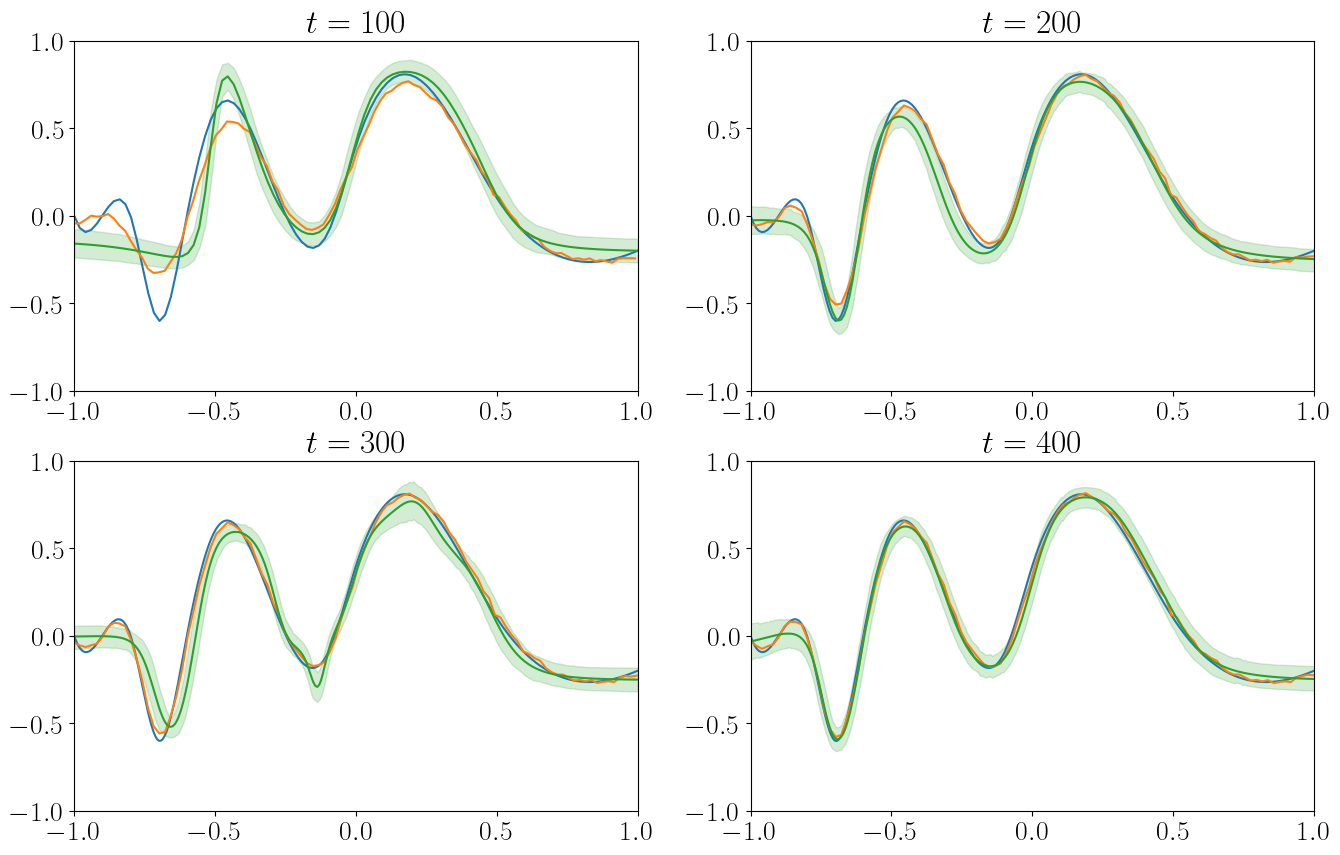

In [14]:
plot_t_subplots('continuous_t.yml', 'continuous','n_t')

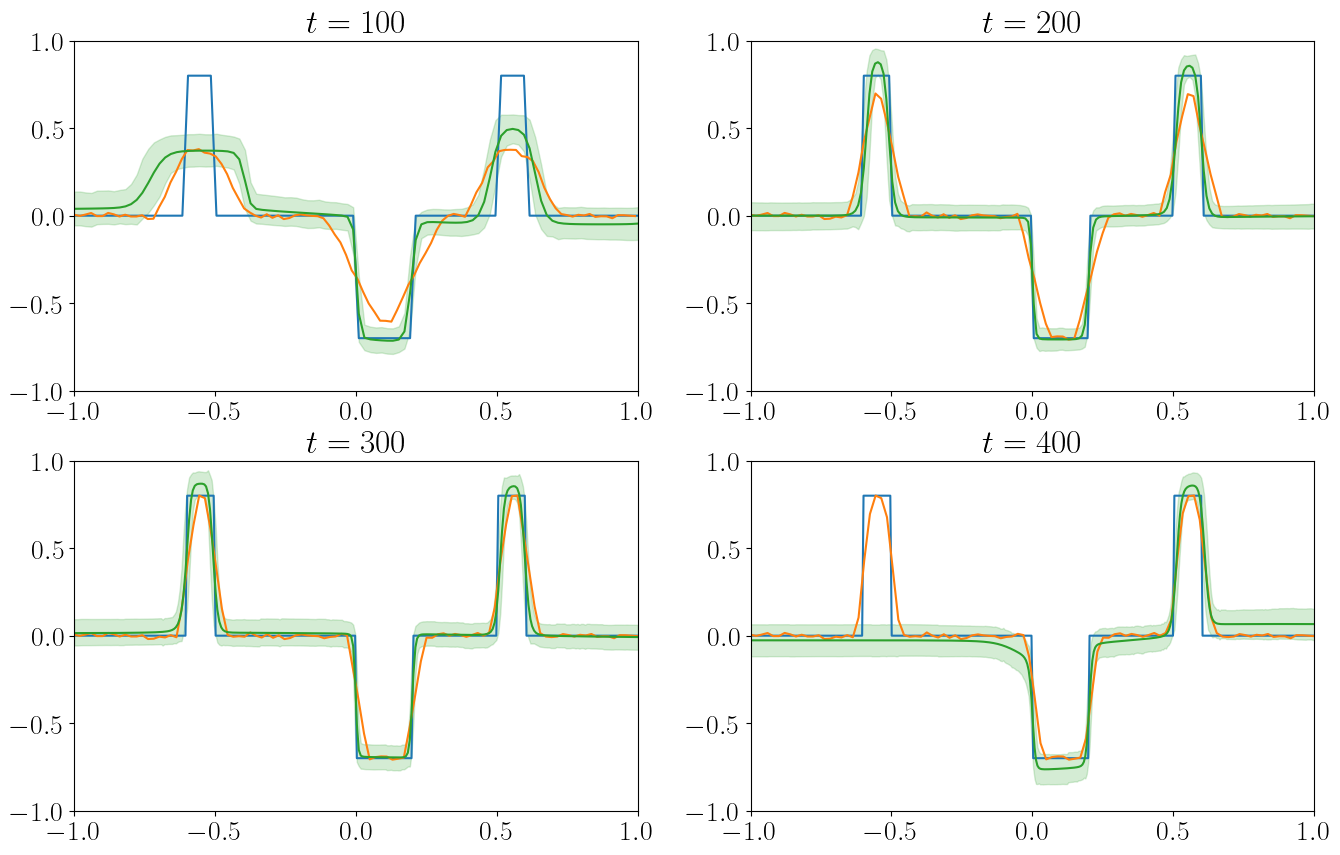

In [15]:
plot_t_subplots('discrete_t.yml', 'discrete','n_t')

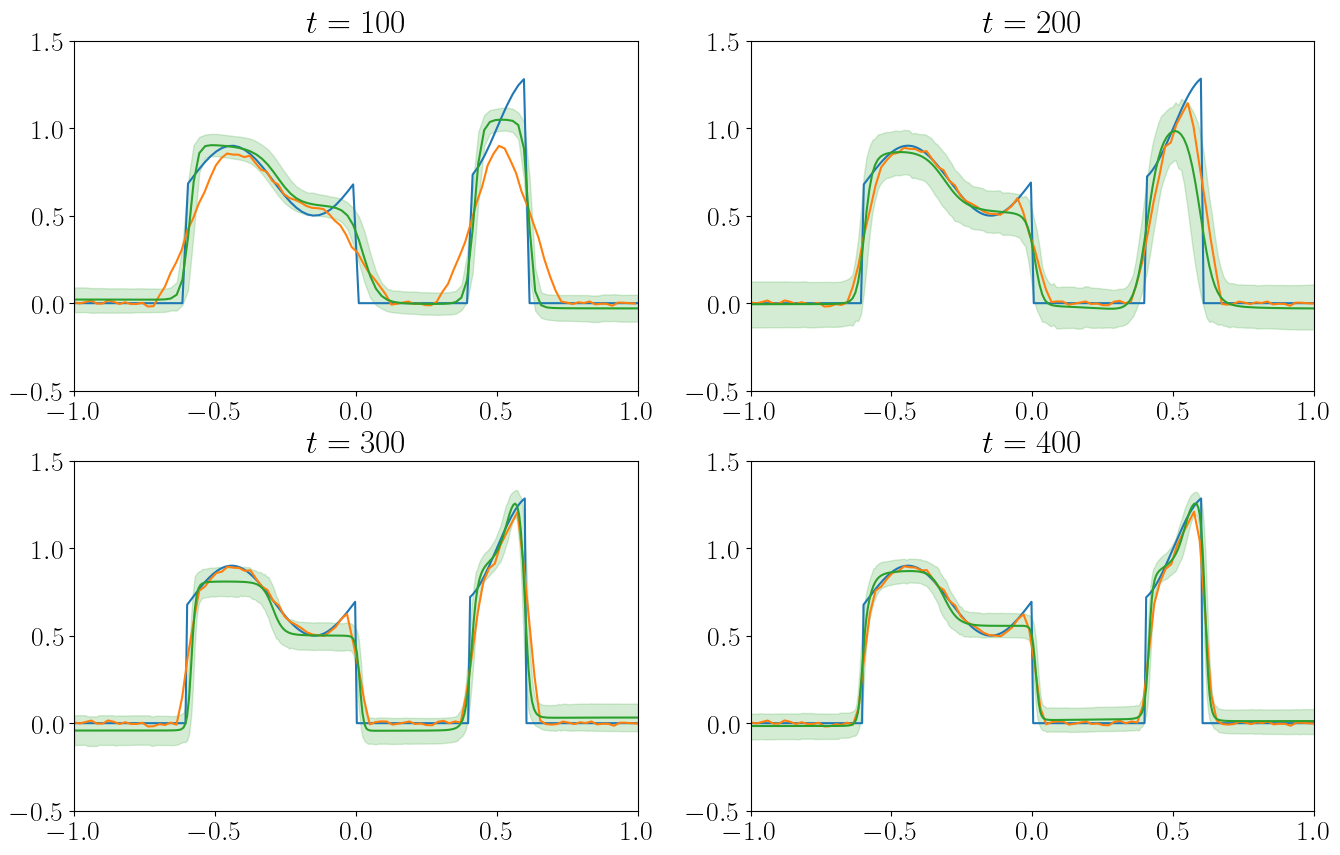

In [16]:
plot_t_subplots('combined_t.yml', 'combined','n_t')

## TRAINING TIMES

In [17]:
def plot_t_subplots(config, problem_type, experiment_type):

    initial = yaml.safe_load(open(f"config/initial.yml"))
    config = yaml.safe_load(open(f"config/{config}"))

    runtimes = np.zeros((4,))
    t_shape = np.zeros((4,))
    with open(f'../results/{problem_type}_initial.pickle', 'rb') as handle:
        initial = pickle.load(handle)
    runtimes[0] = initial['runtime']
    t_shape[0] = len(initial['t'])
    for idx, conf in enumerate(config):
        with open(f'../results/{conf}.pickle', 'rb') as handle:
            data = pickle.load(handle)
        runtimes[idx+1] = data['runtime']
        t_shape[idx+1] = len(data['t'])
    
    plt.plot(t_shape, runtimes)
    #plt.savefig(f"../plots/thesis_images/t_{problem_type}.pdf", format='pdf')

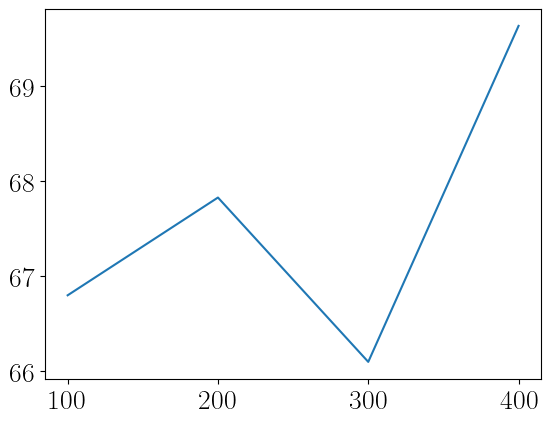

In [18]:
plot_t_subplots('combined_t.yml', 'combined','n_t')

In [12]:
def plot_mcmc_subplots():

    initial = yaml.safe_load(open(f"config/initial.yml"))
    fig, axs = plt.subplots(3, 2, figsize=(16, 10))
    ii, jj = 0, 0

    runtimes = []
    for problem_type in initial:
        with open(f'../results/{problem_type}_initial.pickle', 'rb') as handle:
            data = pickle.load(handle)

        x_mean, lower_quantile, upper_quantile = calculate_mean_and_quantile(data['x_preds'])

        axs[ii, jj].plot(data['t'], data['true'])
        axs[ii, jj].plot(data['x'], data['y_data'])

        line, = axs[ii, jj].plot(data['t'], x_mean, label='inverse solution')
        axs[ii, jj].fill_between(data['t'], lower_quantile, upper_quantile, color=line.get_color(), alpha=0.2, label='90% quantile range')
        
        if problem_type == 'combined':
            axs[ii, jj].axis([domain[0], domain[1], -0.5, 1.5])
        else:
            axs[ii, jj].axis([domain[0], domain[1], -1.0, 1.0])
            
        jj = jj+1

        axs[ii, jj].plot(data['t'], data['true'])
        axs[ii, jj].plot(data['x'], data['y_data'])

        if problem_type == 'combined':
            axs[ii, jj].axis([domain[0], domain[1], -0.5, 1.5])
        else:
            axs[ii, jj].axis([domain[0], domain[1], -1.0, 1.0])
        runtimes.append(data['runtime'])
        with open(f'../results/mcmc_{problem_type}_initial.pickle', 'rb') as handle:
            data = pickle.load(handle)
        
        x_mean, lower_quantile, upper_quantile = calculate_mean_and_quantile(data['x_preds'])

        line, = axs[ii, jj].plot(data['t'], x_mean, label='inverse solution')
        axs[ii, jj].fill_between(data['t'], lower_quantile, upper_quantile, color=line.get_color(), alpha=0.2, label='90% quantile range')
        
        ii = ii+1
        jj = 0
        runtimes.append(data['runtime'])
    #plt.tight_layout()
    plt.savefig(f"../plots/thesis_images/mcmc.pdf", format='pdf')
    print(runtimes)



/home/akseli/anaconda3/lib/python3.9/site-packages/arviz/stats/stats.py:456: FutureWarning: hdi currently interprets 2d data as (draw, shape) but this will change in a future release to (chain, draw) for coherence with other functions
  warnings.warn(


[100.31944632530212, 4410.704083442688, 99.59445333480835, 4560.4384343624115, 105.2131736278534, 12700.828341722488]


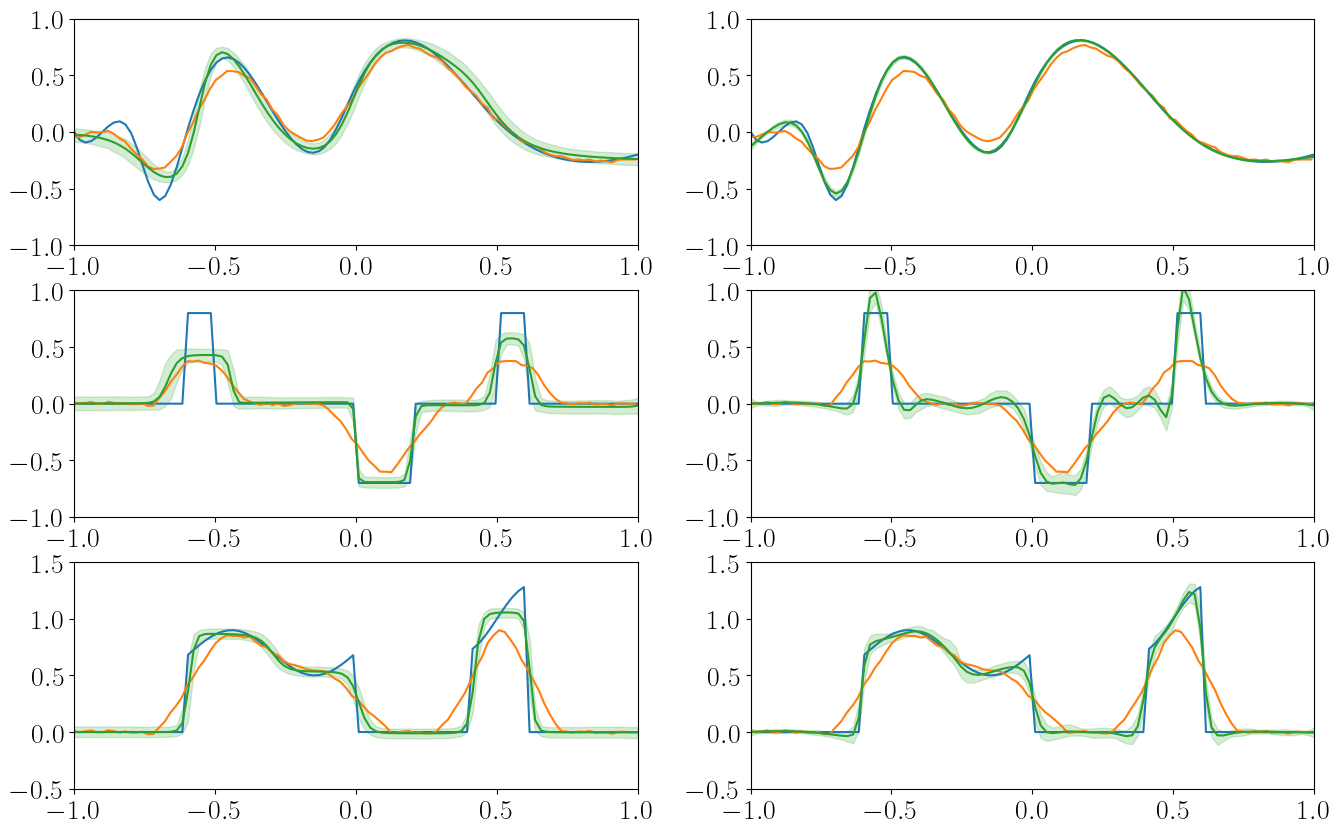

In [13]:
plot_mcmc_subplots()

In [14]:
100/4500

0.022222222222222223